# W207 Summer 2018 Final Project - EDA
### Divya Gorantla, Ram Iyer, Tiffany Jaya, Steve Sanders

### Outline for EDA:

import packages/classes  
read data file  
plot histograms for continuous-variable features  
identify features having missing values  
quantify missing values    
calculate and plot correlation coefficients from initial dataset (uses just the numerical columns)    
perform initial baseline with Random Forest Classifier
drop features that are highly correlated with other features?  
explore feature normality and potential transformations  
explore new composite and/or modified variables  

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix   

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
#from sklearn.grid_search import GridSearchCV   # THIS HAS BEEN DEPRECATED
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier 

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *



In [2]:
train=pd.read_csv('train.csv', index_col='Id') 
test=pd.read_csv('test.csv', index_col='Id') 
orig_train = train.copy() 
orig_test = test.copy() 

In [3]:
print('train shape:', train.shape)
print('test shape:', test.shape)

train shape: (15120, 55)
test shape: (565892, 54)


In [31]:
train_labels = train['Cover_Type']
cover_types = sorted(pd.unique(train['Cover_Type']))
cover_labels = ['Spruce/Fir', 'Lodgepole Pine', 'Ponderosa Pine', 'Cottonwood/Willow', 'Aspen', 'Douglas-fir', 'Krummholz']
wilderness_types = list(range(1,5))
wilderness_labels = ['Rawah', 'Neota', 'Comanche', 'Cache la Poudre']
soil_types = list(range(1,41))
soil_labels = ['Cathedral family', 
               'Vanet', 
               'Haploborolis', 
               'Ratake family',
               'Vanet family',
               'Vanet - Wetmore families',
               'Gothic family',
               'Supervisor',
               'Troutville family',
               'Bullwark - Catamount families',
               'Bullwark - Catamount families',
               'Legault family',
               'Catamount family',
               'Pachic Argiborolis',
               '',
               'Cryaquolis',
               'Gateview family',
               'Rogert family',
               'Typic Cryaquolis',
               'Typic Cryaquepts',
               'Typic Cryaquolls',
               'Leighcan family',
               'Leighcan family',
               'Leighcan family',
               'Leighcan family',
               'Granile',
               'Leighcan family',
               'Leighcan family',
               'Como - Legault families',
               'Como family',
               'Leighcan - Catamount families',
               'Catamount family',
               'Leighcan - Catamount families',
               'Cryorthents',
               'Cryumbrepts',
               'Bross family',
               'Cryumbrepts',
               'Leighcan - Moran families',
               'Moran family - Cryorthents',
               'Moran family - Cryorthents'
              ]

In [29]:
soil_descriptions = ['Rock outcrop complex, extremely stony',
                     'Ratake families complex, very stony',
                     'Rock outcrop complex, rubbly',
                     'Rock outcrop complex, rubbly',
                     'Rock outcrop complex, rubbly',
                     'Rock outcrop complex, stony',
                     '',
                     'Limber families complex',
                     'very stony',
                     'Rock outcrop complex, rubbly',
                     'Rock land complex, rubbly',
                     ' Rock land complex, stony',
                     'Rock land - Bullwark family complex, rubbly',
                     'Aquolis complex',
                     '',
                     'Cryoborolis complex',
                     'Cryaquolis complex',
                     'very stony',
                     'Borohemists complex',
                     'Typic Cryaquolls complex',
                     'Leighcan family, till substratum complex',
                     'till substratum, extremely bouldery',
                     'till substratum, extremely bouldery',
                     'extremely stony',
                     'warm, extremely stony',
                     'Catamount families complex, very stony',
                     'Rock outcrop complex, extremely stony',
                     'Rock outcrop complex, extremely stony',
                     'complex, extremely stony',
                     'Rock land - Legault family complex, extremely stony',
                     'complex, extremely stony',
                     'Rock outcrop - Leighcan family complex, extremely stony',
                     'Rock outcrop complex, extremely stony',
                     'Rock land complex, extremely stony',
                     'Rock outcrop - Cryaquepts complex',
                     'Rock land - Cryumbrepts complex, extremely stony',
                     'Cryumbrepts - Cryorthents complex, extremely stony',
                     'Cryaquolls complex, extremely stony',
                     'Cryorthents - Leighcan family complex, extremely stony',
                     'Cryorthents - Rock land complex, extremely stony'
                    ]

In [5]:
train.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
Id,,,,,,,,,,,,,,,,,,,,,
1,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
2,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
3,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
4,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
5,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [6]:
train.describe()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
count,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,...,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000
mean,2749.322553,156.676653,16.501587,227.195701,51.076521,1714.023214,212.704299,218.965608,135.091997,1511.147288,...,0.045635,0.040741,0.001455,0.006746,0.000661,0.002249,0.048148,0.043452,0.030357,4.000000
std,417.678187,110.085801,8.453927,210.075296,61.239406,1325.066358,30.561287,22.801966,45.895189,1099.936493,...,0.208699,0.197696,0.038118,0.081859,0.025710,0.047368,0.214086,0.203880,0.171574,2.000066
min,1863.000000,0.000000,0.000000,0.000000,-146.000000,0.000000,0.000000,99.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2376.000000,65.000000,10.000000,67.000000,5.000000,764.000000,196.000000,207.000000,106.000000,730.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,2752.000000,126.000000,15.000000,180.000000,32.000000,1316.000000,220.000000,223.000000,138.000000,1256.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
75%,3104.000000,261.000000,22.000000,330.000000,79.000000,2270.000000,235.000000,235.000000,167.000000,1988.250000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000
max,3849.000000,360.000000,52.000000,1343.000000,554.000000,6890.000000,254.000000,254.000000,248.000000,6993.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000


In [7]:
test.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
Id,,,,,,,,,,,,,,,,,,,,,
15121,2680,354,14,0,0,2684,196,214,156,6645,...,0,0,0,0,0,0,0,0,0,0
15122,2683,0,13,0,0,2654,201,216,152,6675,...,0,0,0,0,0,0,0,0,0,0
15123,2713,16,15,0,0,2980,206,208,137,6344,...,0,0,0,0,0,0,0,0,0,0
15124,2709,24,17,0,0,2950,208,201,125,6374,...,0,0,0,0,0,0,0,0,0,0
15125,2706,29,19,0,0,2920,210,195,115,6404,...,0,0,0,0,0,0,0,0,0,0


In [8]:
test.describe()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
count,565892.000000,565892.000000,565892.000000,565892.000000,565892.000000,565892.000000,565892.000000,565892.000000,565892.000000,565892.000000,...,565892.000000,565892.000000,565892.000000,565892.000000,565892.000000,565892.000000,565892.000000,565892.000000,565892.000000,565892.000000
mean,2964.977407,155.629558,14.039635,270.556622,46.294408,2367.143116,212.131133,223.435026,142.726951,1992.826227,...,0.044768,0.091588,0.078704,0.002808,0.003161,0.000193,0.000467,0.026233,0.023236,0.014651
std,273.157030,111.962120,7.450155,212.500153,58.209469,1561.482002,26.661063,19.668053,38.030094,1327.396895,...,0.206795,0.288444,0.269277,0.052916,0.056137,0.013877,0.021594,0.159827,0.150652,0.120152
min,1859.000000,0.000000,0.000000,0.000000,-173.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2818.000000,58.000000,9.000000,108.000000,7.000000,1116.000000,198.000000,213.000000,119.000000,1034.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2999.000000,127.000000,13.000000,228.000000,29.000000,2018.000000,218.000000,226.000000,143.000000,1723.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3164.000000,260.000000,18.000000,390.000000,69.000000,3349.000000,231.000000,237.000000,168.000000,2561.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3858.000000,360.000000,66.000000,1397.000000,601.000000,7117.000000,254.000000,254.000000,254.000000,7173.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**The test set does not have the "Cover_Type" response column.**

In [9]:
train.isnull().sum()

Elevation                             0
Aspect                                0
Slope                                 0
Horizontal_Distance_To_Hydrology      0
Vertical_Distance_To_Hydrology        0
Horizontal_Distance_To_Roadways       0
Hillshade_9am                         0
Hillshade_Noon                        0
Hillshade_3pm                         0
Horizontal_Distance_To_Fire_Points    0
Wilderness_Area1                      0
Wilderness_Area2                      0
Wilderness_Area3                      0
Wilderness_Area4                      0
Soil_Type1                            0
Soil_Type2                            0
Soil_Type3                            0
Soil_Type4                            0
Soil_Type5                            0
Soil_Type6                            0
Soil_Type7                            0
Soil_Type8                            0
Soil_Type9                            0
Soil_Type10                           0
Soil_Type11                           0


There are no "null" cells in the train data set.  

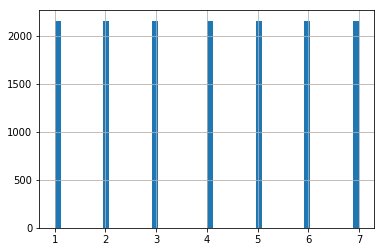

In [10]:
# Look at the output variable: Cover_Type

train.Cover_Type.hist(bins=50) 
plt.show()

In [20]:
train.groupby('Cover_Type').size()

Cover_Type
1    2160
2    2160
3    2160
4    2160
5    2160
6    2160
7    2160
dtype: int64

The train data has a uniform distribution of Cover_Type values.

### Elevation

In [36]:
# visualize elevation by cover types# visual 
# 1. count the number of cover types per elevation
#plt_ct_per_el = pd.DataFrame(pd.crosstab(train['Elevation'], train['Cover_Type']).values.tolist(),
#                             columns=sorted(pd.unique(train['Cover_Type'])))

plt_ct_per_el = pd.DataFrame(pd.crosstab(train['Elevation'], train['Cover_Type']).values.tolist(),
                             columns=cover_labels)

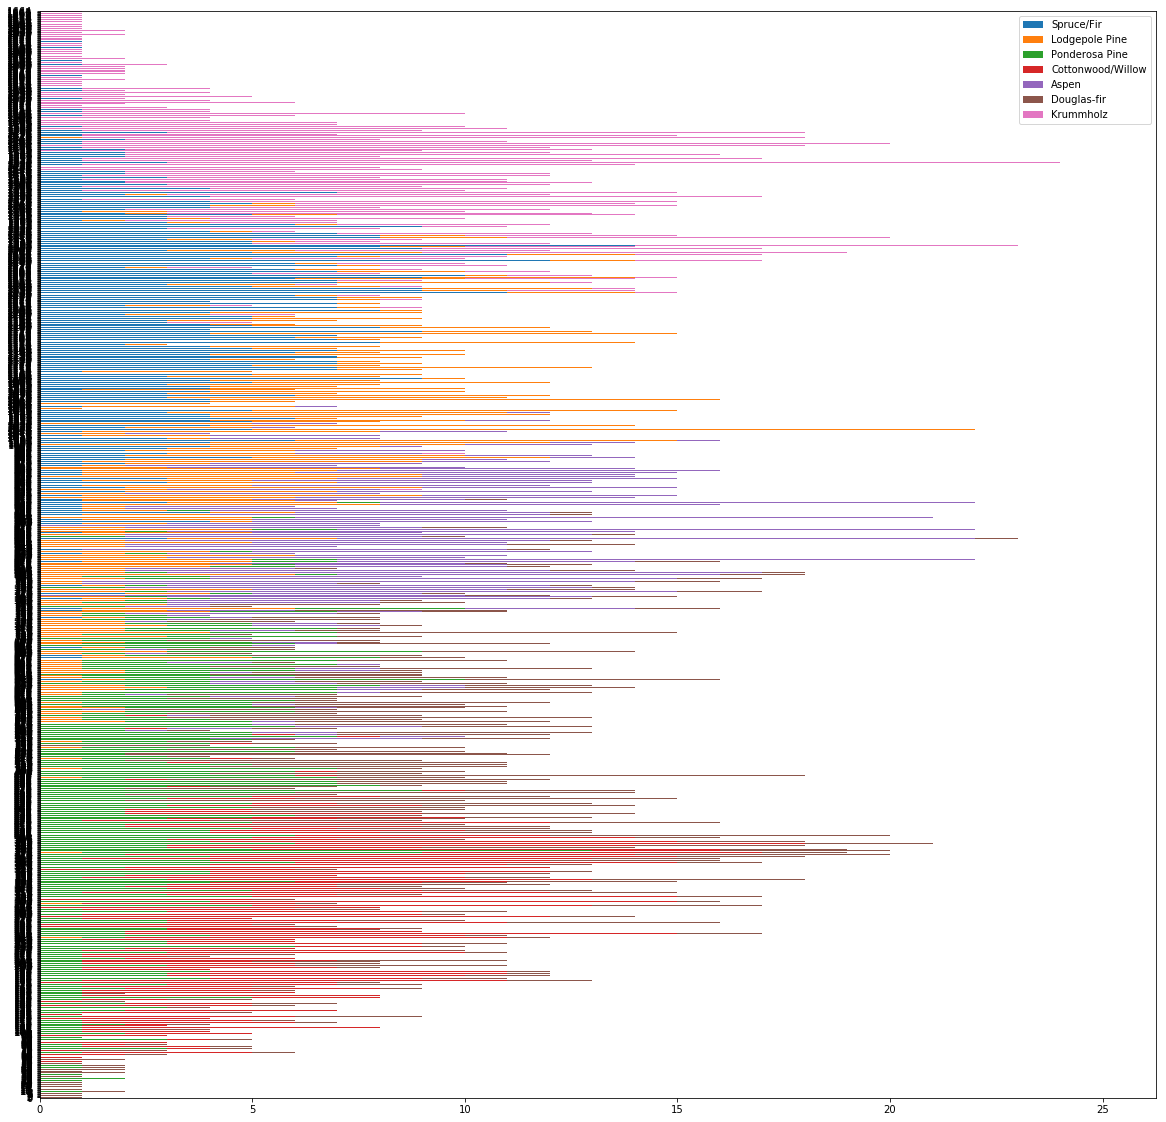

In [34]:
# 2. plot the associating horizontal, stacked graph
_= plt_ct_per_el.plot.barh(stacked=True, figsize=(20, 20))

From the graph shown above, it appears that the cover types most commonly found at the high altitude is Krummholz (which is not surprising because Krummholz are stunted windblown trees situated typically on the top of the mountain) followed by the following cover types found in descending order of altitudes:

  - Krummholz
  - Spruce/Fir 
  - Lodgepole Pine
  - Aspen
  - Ponderosa Pine 
  - Douglas-fir
  - Cottonwood/Willow
  
The elevation graph is better represented in the histogram below.

Feature Engineering

 1. Elevation - Elevation in meters
 2. Aspect - Aspect in degrees azimuth
 3. Slope - Slope in degrees
 4. Horizontal_Distance_To_Hydrology - Horz Dist to nearest surface water features
 5. Vertical_Distance_To_Hydrology - Vert Dist to nearest surface water features
 6. Horizontal_Distance_To_Roadways - Horz Dist to nearest roadway
 7. Hillshade_9am (0 to 255 index) - Hillshade index at 9am, summer solstice
 8. Hillshade_Noon (0 to 255 index) - Hillshade index at noon, summer solstice
 9. Hillshade_3pm (0 to 255 index) - Hillshade index at 3pm, summer solstice
 10. Horizontal_Distance_To_Fire_Points - Horz Dist to nearest wildfire ignition points
 11. Wilderness_Area (4 binary columns, 0 = absence or 1 = presence) - Wilderness area designation
 12. Soil_Type (40 binary columns, 0 = absence or 1 = presence) - Soil Type designation
 13. Cover_Type (7 types, integers 1 to 7) - Forest Cover Type designation

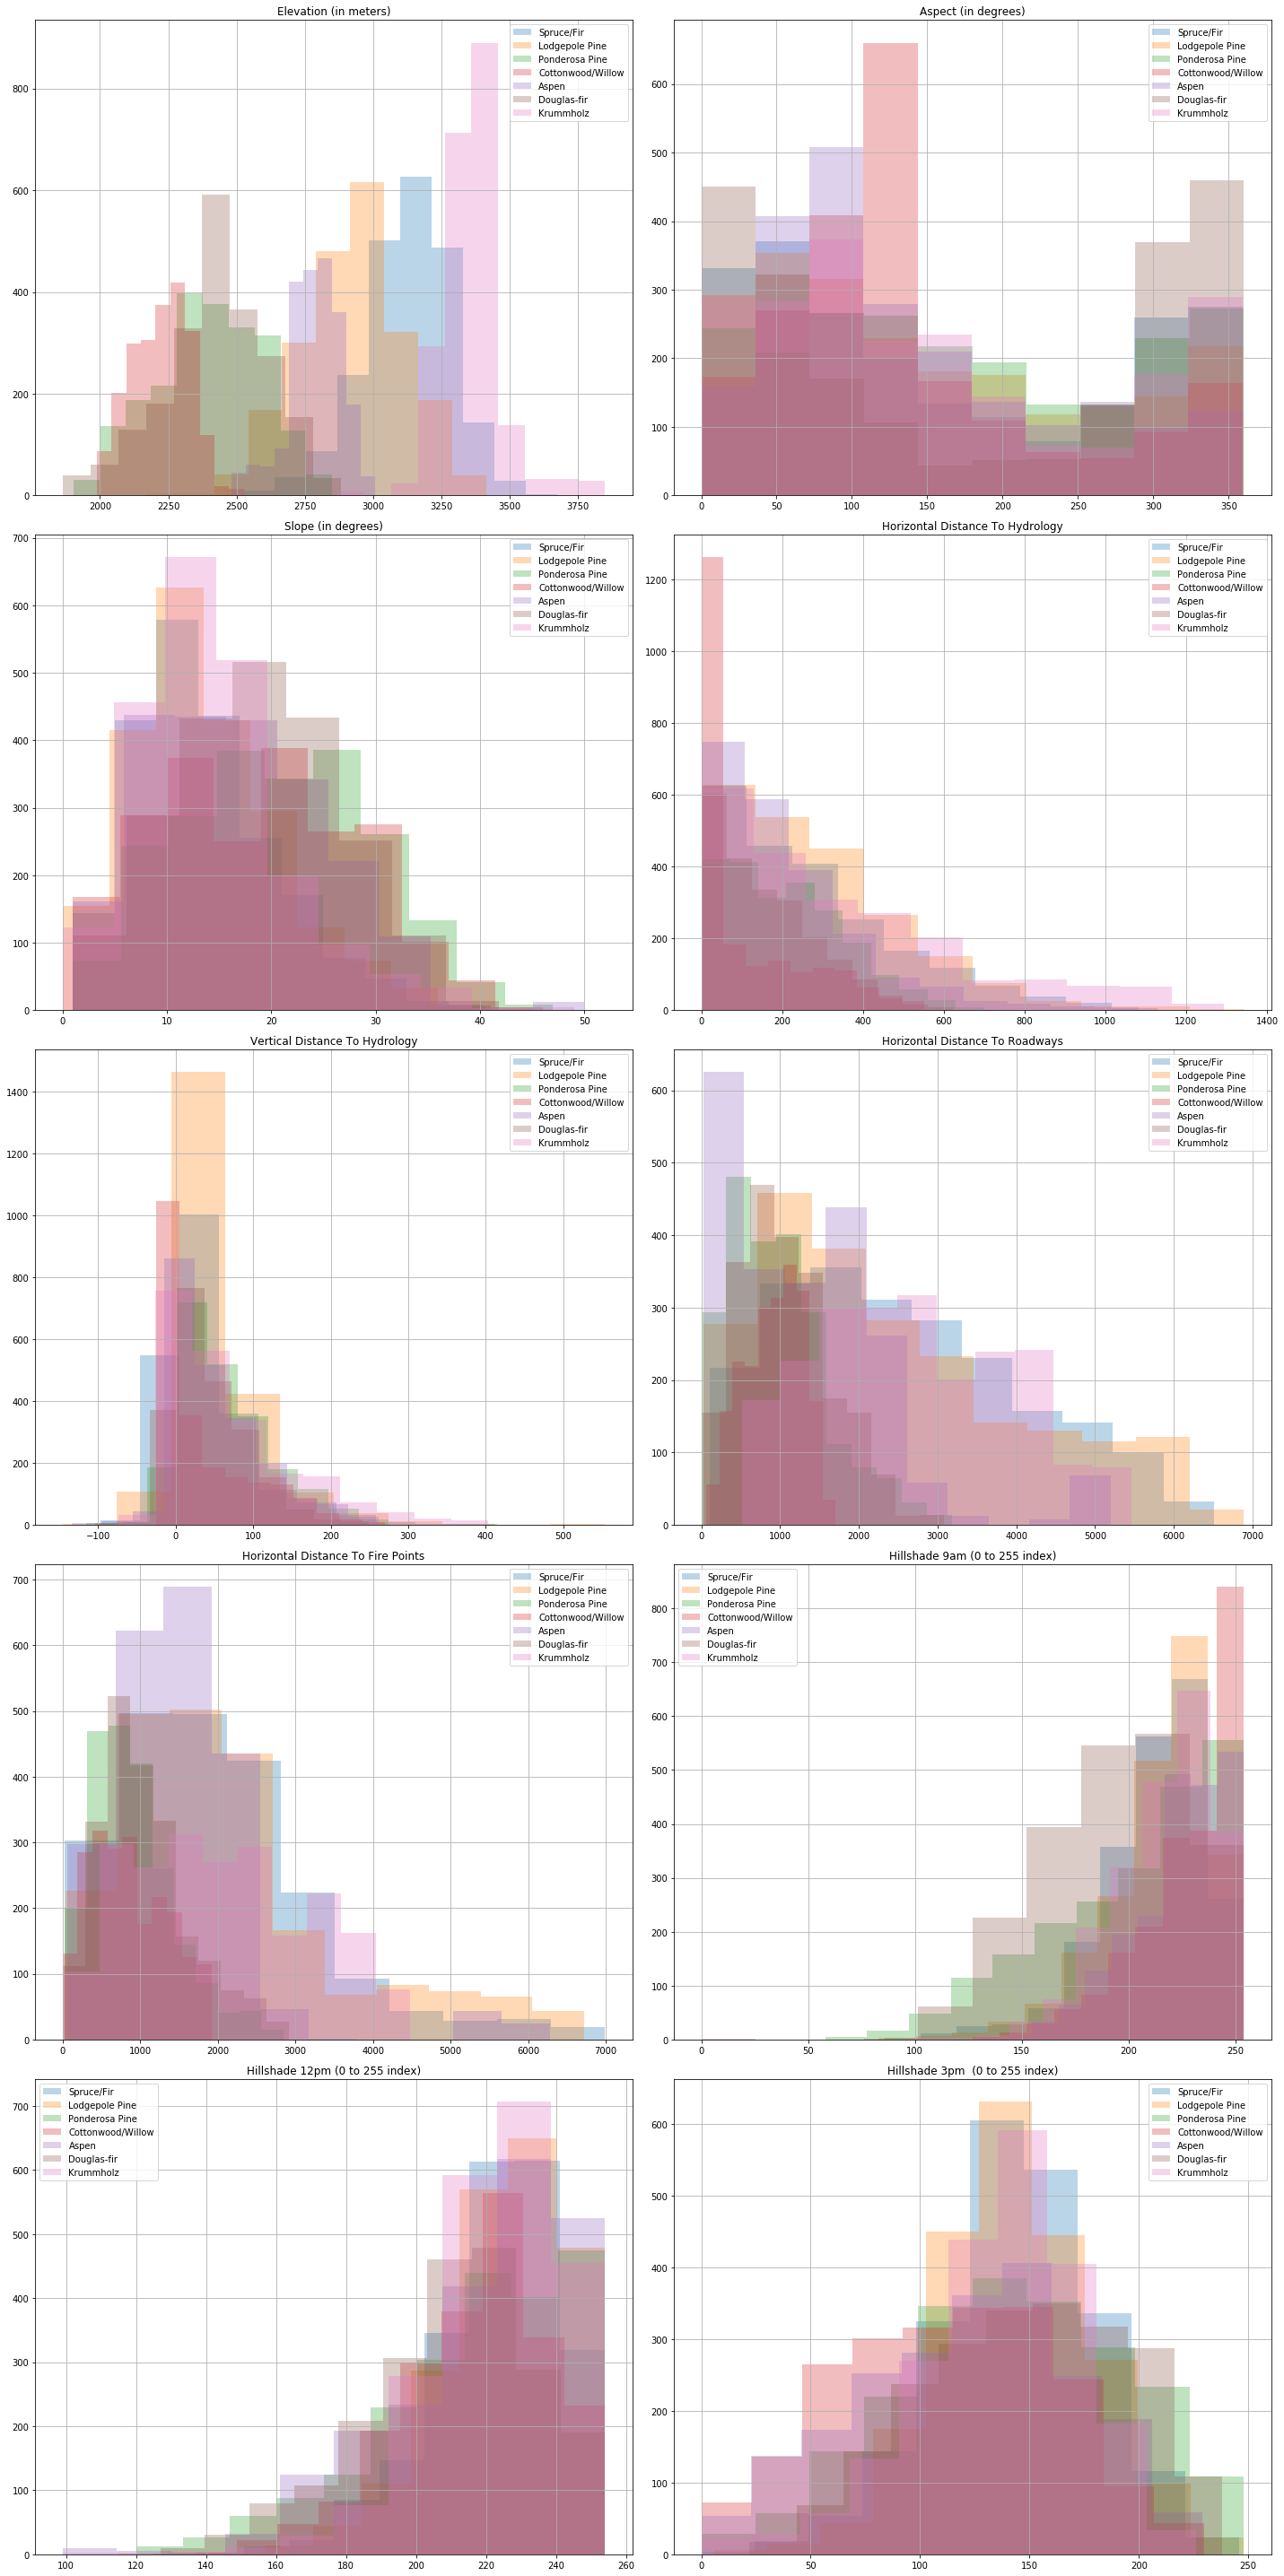

In [37]:
# plot histogram of each column (aka feature)

# 1. plot without overlay
#for column in train.columns[1:11]: 
#    train.groupby('Cover_Type').hist(column=column, alpha=0.3)

# 2. plot with overlay
nrows = 5
ncols = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20,40))
(ax_elevation, 
 ax_aspect, 
 ax_slope, 
 ax_hd_h20, 
 ax_vd_h20, 
 ax_hd_roadways, 
 ax_hd_firepoints, 
 ax_hillshade_9am, 
 ax_hillshade_12pm, 
 ax_hillshade_3pm)= axes.flatten() 

for label, data in train.groupby('Cover_Type')['Elevation']:
    data.hist(alpha=0.3, ax=ax_elevation)
ax_elevation.set_title('Elevation (in meters)')
ax_elevation.legend(labels=cover_labels)

for label, data in train.groupby('Cover_Type')['Aspect']:
    data.hist(alpha=0.3, ax=ax_aspect)
ax_aspect.set_title('Aspect (in degrees)')
ax_aspect.legend(labels=cover_labels)

for label, data in train.groupby('Cover_Type')['Slope']:
    data.hist(alpha=0.3, ax=ax_slope)
ax_slope.set_title('Slope (in degrees)')
ax_slope.legend(labels=cover_labels)

for label, data in train.groupby('Cover_Type')['Horizontal_Distance_To_Hydrology']:
    data.hist(alpha=0.3, ax=ax_hd_h20)
ax_hd_h20.set_title('Horizontal Distance To Hydrology')
ax_hd_h20.legend(labels=cover_labels)

for label, data in train.groupby('Cover_Type')['Vertical_Distance_To_Hydrology']:
    data.hist(alpha=0.3, ax=ax_vd_h20)
ax_vd_h20.set_title('Vertical Distance To Hydrology')
ax_vd_h20.legend(labels=cover_labels)

for label, data in train.groupby('Cover_Type')['Horizontal_Distance_To_Roadways']:
    data.hist(alpha=0.3, ax=ax_hd_roadways)
ax_hd_roadways.set_title('Horizontal Distance To Roadways')
ax_hd_roadways.legend(labels=cover_labels)

for label, data in train.groupby('Cover_Type')['Horizontal_Distance_To_Fire_Points']:
    data.hist(alpha=0.3, ax=ax_hd_firepoints)
ax_hd_firepoints.set_title('Horizontal Distance To Fire Points')
ax_hd_firepoints.legend(labels=cover_labels)

for label, data in train.groupby('Cover_Type')['Hillshade_9am']:
    data.hist(alpha=0.3, ax=ax_hillshade_9am)
ax_hillshade_9am.set_title('Hillshade 9am (0 to 255 index)')
ax_hillshade_9am.legend(labels=cover_labels)

for label, data in train.groupby('Cover_Type')['Hillshade_Noon']:
    data.hist(alpha=0.3, ax=ax_hillshade_12pm)
ax_hillshade_12pm.set_title('Hillshade 12pm (0 to 255 index)')
ax_hillshade_12pm.legend(labels=cover_labels)

for label, data in train.groupby('Cover_Type')['Hillshade_3pm']:
    data.hist(alpha=0.3, ax=ax_hillshade_3pm)
ax_hillshade_3pm.set_title('Hillshade 3pm  (0 to 255 index)')
ax_hillshade_3pm.legend(labels=cover_labels)

fig.tight_layout()
plt.show()

From the plot above, "Evaluation" makes a good feature because there is not much overlap between the different tree types.


### Aspect

From the polar plot, it reconfirms that elevation plays a greater role in identifying the cover type. There's a cover type in almost every aspect (360 degree).

Other plot that we might want to try: https://stackoverflow.com/questions/45396750/matplotlib-azimuth-vs-elevation-discontinuity-at-origin

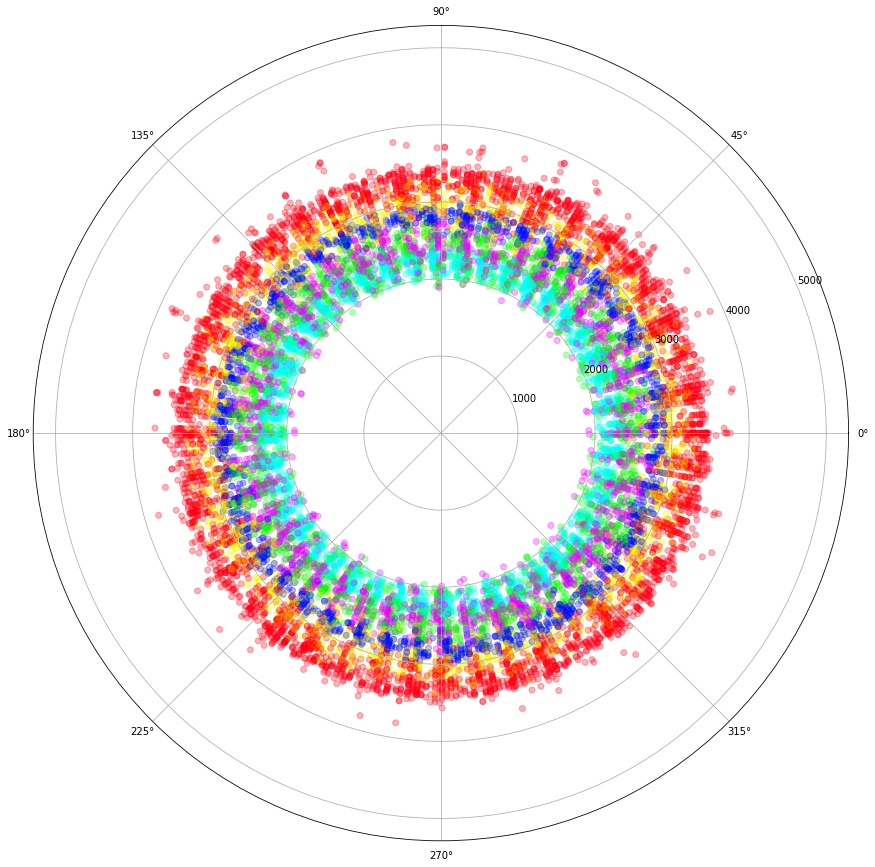

In [39]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,15))
ax = plt.subplot(111, projection='polar')
_ = ax.scatter(train['Aspect'], train['Elevation'], c=train['Cover_Type'], cmap='hsv', alpha=0.3)

In [40]:
# There are 10 continuous-variable features in this data
continuous_var = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points' ]

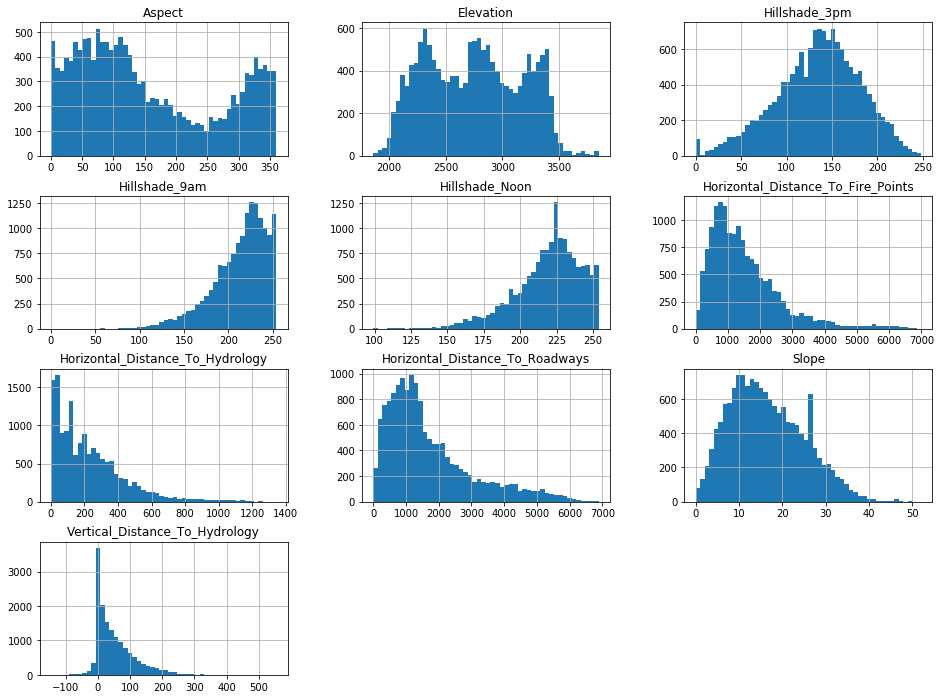

In [41]:
# Look at the continuous features:
_ = train.iloc[:,:10].hist(figsize=(16,12),bins=50)

### Observations from histograms of continuous-variable features:
Aspect is rotational, so the value at 360 degrees should equal the value at 0 degrees.  (This represents the compass direction that the slope (surface of the hill) faces, based on azimuth angle, where 0 degrees is North and 90 degrees is East.)  

Elevation appears to have 3 modes.  

Hillshade_3pm has several zero values that appear to be out of place (i.e., "missing values"). 
Hillshade_9am and Hillshade_Noon are truncated at 255, which is the maximum value of the index.  

The distance-based features have substantial right-hand skew.   

Slope appears to have extra data at a value around 27 degrees.  

Vertical_Distance_to_Hydrology has several negative values.  


In [42]:
train[continuous_var].corr()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points
Elevation,1.000000,-0.011096,-0.312640,0.412712,0.122092,0.578659,0.097900,0.215782,0.089518,0.443563
Aspect,-0.011096,1.000000,0.028148,0.040732,0.056412,0.066184,-0.593997,0.324912,0.635022,-0.052169
Slope,-0.312640,0.028148,1.000000,-0.055976,0.265314,-0.277049,-0.200072,-0.612613,-0.326887,-0.239527
Horizontal_Distance_To_Hydrology,0.412712,0.040732,-0.055976,1.000000,0.652142,0.203397,-0.033803,0.080047,0.080833,0.158817
Vertical_Distance_To_Hydrology,0.122092,0.056412,0.265314,0.652142,1.000000,0.011555,-0.095930,-0.132948,-0.035559,-0.015048
Horizontal_Distance_To_Roadways,0.578659,0.066184,-0.277049,0.203397,0.011555,1.000000,-0.003398,0.240684,0.173882,0.486386
Hillshade_9am,0.097900,-0.593997,-0.200072,-0.033803,-0.095930,-0.003398,1.000000,-0.013712,-0.779965,0.078144
Hillshade_Noon,0.215782,0.324912,-0.612613,0.080047,-0.132948,0.240684,-0.013712,1.000000,0.614526,0.122098
Hillshade_3pm,0.089518,0.635022,-0.326887,0.080833,-0.035559,0.173882,-0.779965,0.614526,1.000000,0.043162
Horizontal_Distance_To_Fire_Points,0.443563,-0.052169,-0.239527,0.158817,-0.015048,0.486386,0.078144,0.122098,0.043162,1.000000


AxesSubplot(0.125,0.125;0.62x0.755)


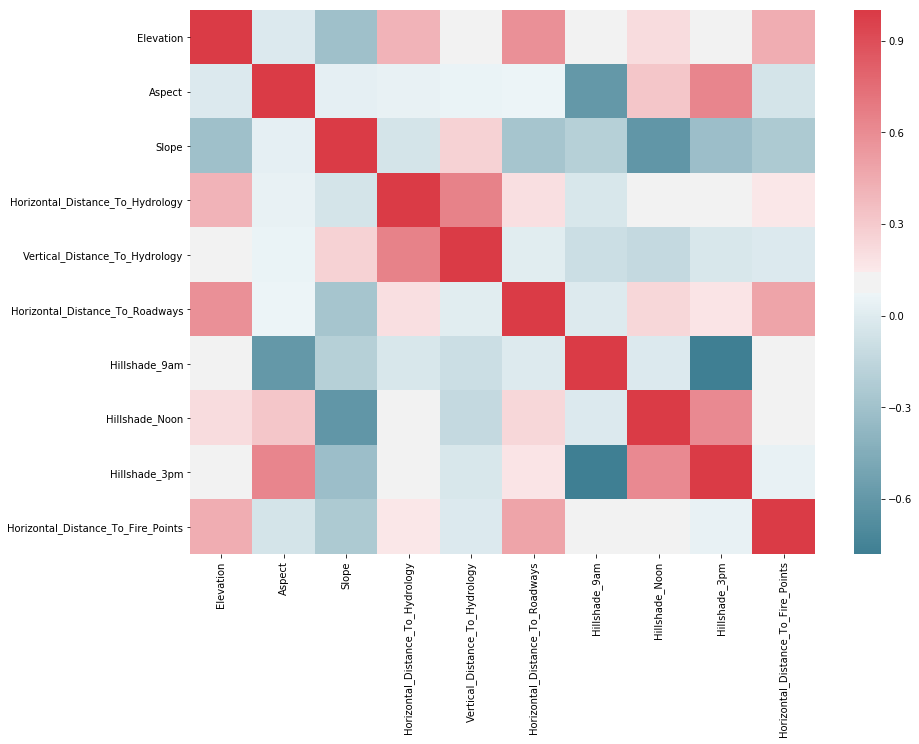

In [43]:
# plot correlation map of continuous features in train data

plt.figure(figsize=(14, 10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)   #Creates a Matplotlib color map
correlations = train[continuous_var].corr()
# print correlations
print(sns.heatmap(correlations, cmap=cmap))


The hillshade at Noon/ hillshade at 3pm show a high degree of positive correlation
The hillshade at 9AM vs 3pm show a high degree of negative correlation

Aspect has negative correlation with hillshades at 9AM and Noon

Horizontal and Vertical distance to hydrology are highly positively correlated

Slope and hillshade have high correlation

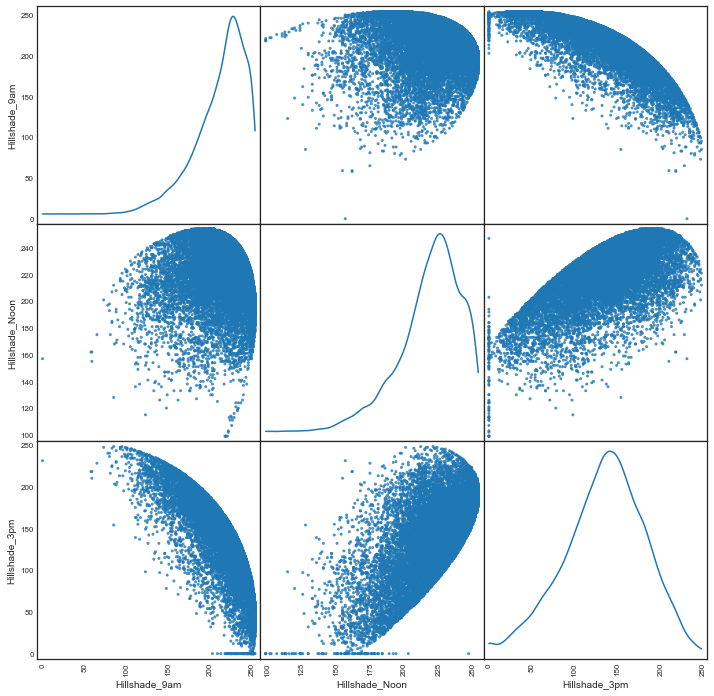

In [34]:
# See how Hillside features are related.

with seaborn.axes_style('white'): 
    hillside = train[['Hillshade_9am', 'Hillshade_Noon','Hillshade_3pm']] 
    scatter_matrix(hillside, alpha=0.8, figsize=(12, 12), diagonal="kde") 
    plt.show() 

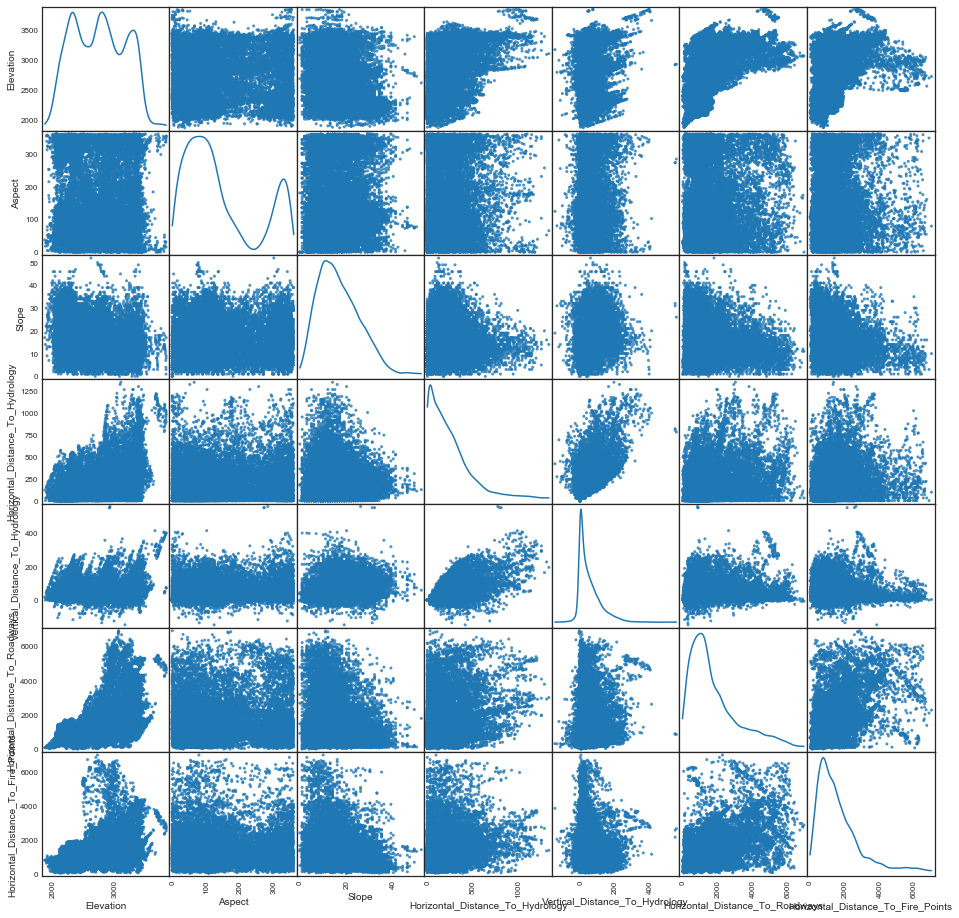

In [37]:
# See how the other continuous features are related.

with seaborn.axes_style('white'): 
    other_cont = train[['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points']] 
    scatter_matrix(other_cont, alpha=0.8, figsize=(16, 16), diagonal="kde") 
    plt.show()

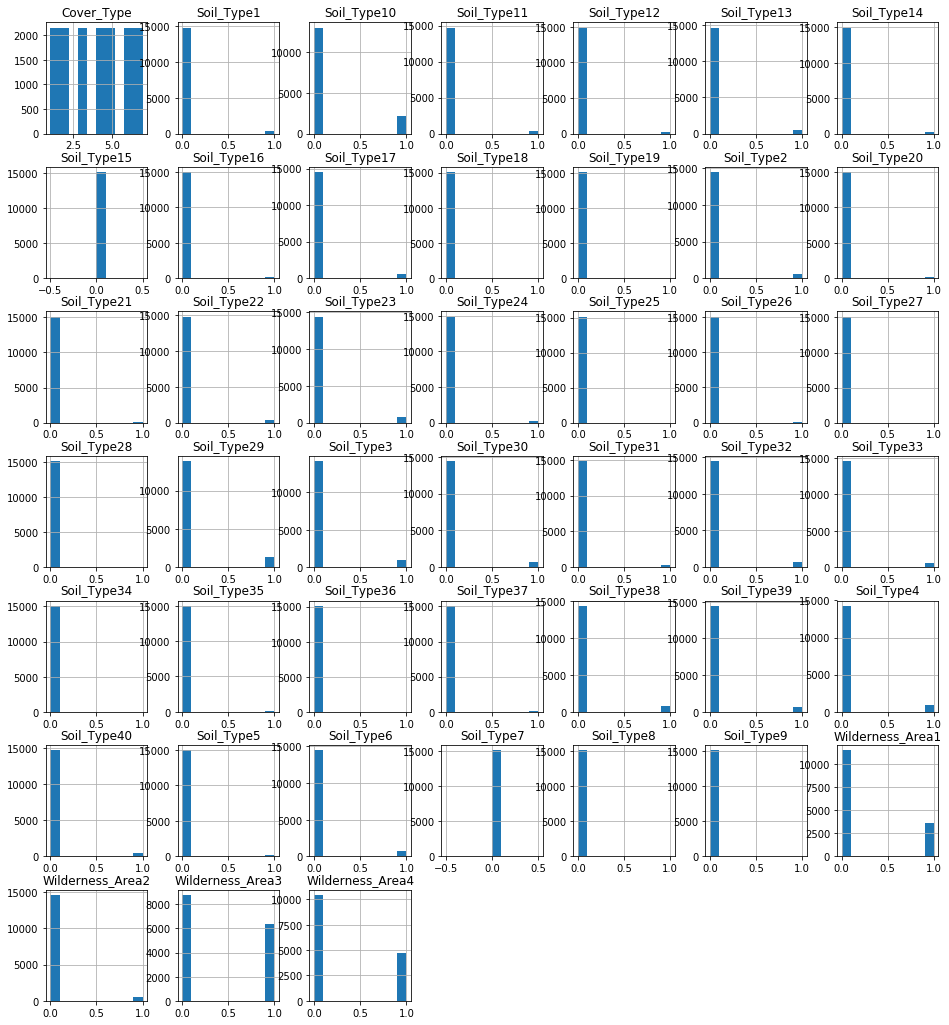

In [13]:
# Look at the binary features:
_ = train.iloc[:, 10:].hist(figsize=(16,18),bins=10)

Several soil types are under-represented, including 7 and 15, which have no representation.

Wilderness_Area2 is under-represented relative to the other 3 Wilderness_Area types.

In [45]:
X_train = train.iloc[:,:-1].values
y_train = train.iloc[:,-1:].values.ravel()

                                    importance
feature                                       
Elevation                                0.226
Horizontal_Distance_To_Roadways          0.095
Horizontal_Distance_To_Fire_Points       0.074
Horizontal_Distance_To_Hydrology         0.062
Vertical_Distance_To_Hydrology           0.055
Aspect                                   0.050
Hillshade_9am                            0.049
Hillshade_3pm                            0.047
Hillshade_Noon                           0.043
Wilderness_Area4                         0.041
Slope                                    0.036
Soil_Type10                              0.025
Wilderness_Area1                         0.020
Soil_Type3                               0.020
Soil_Type39                              0.019
Soil_Type38                              0.017
Wilderness_Area3                         0.016
Soil_Type4                               0.012
Soil_Type40                              0.010
Soil_Type2   

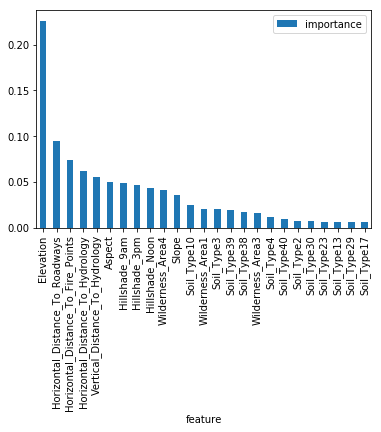

In [48]:
# Sort the features by importance

rf_initial=RandomForestClassifier(n_estimators=40, bootstrap=True, oob_score=True)

rf_initial.fit(X_train,y_train)

best_features = pd.DataFrame({'feature':train.columns[:-1],'importance':np.round(rf_initial.feature_importances_,3)})
best_features = best_features.sort_values('importance',ascending=False).set_index('feature')[:25]

print(best_features)
best_features.plot.bar()

In [ ]:
# Do a randomized search on the initial tree implementation for the baseline model. 
# This model is used for the initial submission


from sklearn.model_selection import RandomizedSearchCV

model = RandomForestClassifier()
param_grid = {'n_estimators':np.linspace(10,50,20,dtype=int), 'max_depth':np.linspace(10,100,20,dtype=int)}

rsearch_tree = RandomizedSearchCV(estimator = model, param_distributions=param_grid,n_iter=50,cv=5)

rsearch_tree.fit(X_train,y_train)
print(rsearch_tree)

In [52]:
print(" Best Estimator, number of trees ",rsearch_tree.best_estimator_.n_estimators)

 Best Estimator, number of trees  50


In [50]:
print(" Best Estimator, max tree depth", rsearch_tree.best_estimator_.max_depth)

 Best Estimator, max tree depth 76


In [49]:
mean_score = np.mean(rsearch_tree.cv_results_['mean_test_score'])
std_score  = np.std(rsearch_tree.cv_results_['mean_test_score'])
print("Mean cross validation score {:7.4f}, std dev of scores :{:7.4f}".format(mean_score,std_score))

Mean cross validation score  0.7682, std dev of scores : 0.0118


In [54]:
# Fit the baseline model with the cross validates params on the original feature set

baseline_model = RandomForestClassifier(n_estimators=50,max_depth=76)
baseline_model.fit(X_train,y_train)

scores = cross_val_score(baseline_model, X_train, y_train,cv=10)

print("Baseline model score, mean : {:7.4f}, stdDev : {:7.4f}".format(np.mean(scores),np.std(scores)))

Baseline model score, mean :  0.7762, stdDev :  0.0412


In [55]:
# Logistic regression with all original features

model = LogisticRegression()
param_grid = {'C':np.linspace(0.1,10,1000)}

rsearch_all = RandomizedSearchCV(estimator = model, param_distributions=param_grid,n_iter=20,cv=10)

rsearch_all.fit(X_train,y_train)
print(rsearch_all)
print()

print("Best estimated C value",rsearch_all.best_estimator_.C)

mean_score = np.mean(rsearch_all.cv_results_['mean_test_score'])
std_score  = np.std(rsearch_all.cv_results_['mean_test_score'])
print("Mean cross validation score {:7.4f}, std dev of scores :{:7.4f}".format(mean_score,std_score))

RandomizedSearchCV(cv=10, error_score='raise',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=20, n_jobs=1,
          param_distributions={'C': array([ 0.1    ,  0.10991, ...,  9.99009, 10.     ])},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)
Best estimated C value 8.523423423423424
Mean cross validation score  0.6275, std dev of scores : 0.0028


In [57]:

## Try out KNN with the original feature set

k_range = list(range(1,71,2))
weight_options = ['uniform','distance']
param_grid = {"n_neighbors":k_range,"weights":weight_options}

model = KNeighborsClassifier()

%time rsearch_knn = RandomizedSearchCV(estimator = model, param_distributions=param_grid,n_iter=20,cv=10)

rsearch_knn.fit(X_top20,y_top20)

print(rsearch_knn)
print()

print("Best estimated n_neighbors value",rsearch_knn.best_estimator_.n_neighbors)
print("Best estimated weights value",rsearch_knn.best_estimator_.weights)
print()

mean_score = np.mean(rsearch_knn.cv_results_['mean_test_score'])
std_score  = np.std(rsearch_knn.cv_results_['mean_test_score'])
print("Mean cross validation score {:7.4f}, std dev of scores :{:7.4f}".format(mean_score,std_score))

CPU times: user 12 µs, sys: 1 µs, total: 13 µs
Wall time: 16.2 µs
RandomizedSearchCV(cv=10, error_score='raise',
          estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
          fit_params=None, iid=True, n_iter=20, n_jobs=1,
          param_distributions={'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67, 69], 'weights': ['uniform', 'distance']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

Best estimated n_neighbors value 1
Best estimated weights value uniform

Mean cross validation score  0.6326, std dev of scores : 0.0409


In [ ]:

# Try out the Support Vector Machine classifier with the original feature set
## Note that this is super slow in terms of training time, so avoid running this cell unless absolutely needed.

from sklearn import svm

param_grid = {
    'C':            np.arange( 1, 10+1, 1 ).tolist(),
    'kernel':       ['linear', 'rbf'],                   
    'gamma':        np.arange( 0.0, 10.0+0.1, 0.1 ).tolist(),
    }

model = svm.SVC()

rsearch_svm = RandomizedSearchCV(estimator = model, param_distributions=param_grid,n_iter=10,cv=10)

rsearch_svm.fit(X_train,y_train)

print(rsearch_svm)
print(rsearch_svm.best_score_)
print(rsearch_svm.best_estimator_.C)
print(rsearch_svm.best_estimator_.kernel)
print(rsearch.svm.best_estimator_gamma)

mean_score = np.mean(rsearch_svm.cv_results_['mean_test_score'])
std_score  = np.std(rsearch_svm.cv_results_['mean_test_score'])
print("Mean cross validation score {:7.4f}, std dev of scores :{:7.4f}".format(mean_score,std_score))

In [56]:

## TODO - SCALE features before trying out Naive Bayes ###

'''
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

alpha = np.geomspace(0.001,10,100)
param_grid = {"multinomialnb__alpha":alpha}

pipe = (StandardScaler(),MultinomialNB)

rsearch_nb = RandomizedSearchCV(estimator = pipe, param_distributions=param_grid,n_iter=50,cv=10)
print(rsearch_nb)

print(X_train.shape)
print(y_train.shape)
print(alpha)
'''

'\nfrom sklearn.preprocessing import StandardScaler\nfrom sklearn.pipeline import make_pipeline\n\nalpha = np.geomspace(0.001,10,100)\nparam_grid = {"multinomialnb__alpha":alpha}\n\npipe = (StandardScaler(),MultinomialNB)\n\nrsearch_nb = RandomizedSearchCV(estimator = pipe, param_distributions=param_grid,n_iter=50,cv=10)\nprint(rsearch_nb)\n\nprint(X_train.shape)\nprint(y_train.shape)\nprint(alpha)\n'

In [20]:
#Make a copy of the test file 
temp_test = test.copy() 

#Run Predictions on temp_test
temp_test['Cover_Type'] = rsearch_tree.predict(temp_test.values) 


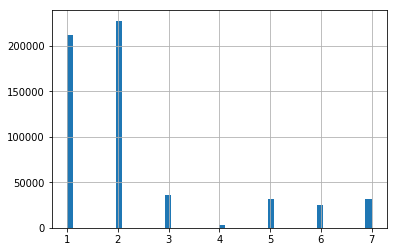

In [21]:
# There are no test labels to compare to, so just plot the distribution of the predicted classes.  

temp_test.Cover_Type.hist(bins=50) 
plt.show()

We observe that the predicted Cover_Type classes from the test data are highly weighted toward Cover_Type's 1 and 2.  

In [27]:

temp_test["Cover_Type"].to_csv('RF-Initial.csv', header=True)

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
Id,,,,,,,,,,,,,,,,,,,,,
15121,2680,354,14,0,0,2684,196,214,156,6645,...,0,0,0,0,0,0,0,0,0,2
15122,2683,0,13,0,0,2654,201,216,152,6675,...,0,0,0,0,0,0,0,0,0,2
15123,2713,16,15,0,0,2980,206,208,137,6344,...,0,0,0,0,0,0,0,0,0,1
15124,2709,24,17,0,0,2950,208,201,125,6374,...,0,0,0,0,0,0,0,0,0,2
15125,2706,29,19,0,0,2920,210,195,115,6404,...,0,0,0,0,0,0,0,0,0,1


### Observations/Questions 
The test set does not have the "Cover_Type" response column.  
There are no "null" cells in the train data set.   
The train data has a uniform distribution of Cover_Type values.  
Aspect is rotational, so the value at 360 degrees should equal the value at 0 degrees.  
Elevation appears to have 3 modes.  
Hillshade_3pm has several zero values that appear to be out of place (i.e., "missing values"). 
Hillshade_9am and Hillshade_Noon are truncated at 255, which is the maximum value of the index.  
The distance-based features have substantial right-hand skew.   
Slope appears to have extra data at a value around 27 degrees.  
Vertical_Distance_to_Hydrology has several negative values.   
Several soil types are under-represented, including 7 and 15, which have no representation.  
Wilderness_Area2 is under-represented relative to the other 3 Wilderness_Area types.  
Ran a Random Forest Classifier to get an initial baseline.  The RFC fit the train data perfectly. The predicted Cover_Type classes from the test data are highly weighted toward Cover_Type's 1 and 2. 

Are we assuming this data were all collected "simultaneously"?  If collected over a number of weeks/months, then I would expect a time dependence, particularly with the Hillside variables.  



### To Do  
submit baseline test predictions to Kaggle to get result of test predictions?  (From Ref 4., expect ~ 0.75 accuracy.)
further examine the binary features; consider consolidation (e.g., perhaps rocky vs. non-rocky soil)?  
quantify missing values  
drop features that are highly correlated with other features?  
explore feature normality and potential transformations (e.g., log transforms)   
explore new composite and/or modified (input) variables  
construct weighting factors to compensate for non-uniform predicted test labels?  
  

### References
1. https://www.kaggle.com/c/forest-cover-type-kernels-only  
2. http://nbviewer.jupyter.org/github/aguschin/kaggle/blob/master/forestCoverType_featuresEngineering.ipynb  
3. https://cseweb.ucsd.edu/~jmcauley/cse255/reports/wi15/Yerlan_Idelbayev.pdf  
4. https://shankarmsy.github.io/posts/forest-cover-types.html  
5. https://www.fs.fed.us/rm/pubs_other/rmrs_2007_stage_a002.pdf  